In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.projections import get_projection_class

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats

# Import my modules
sys.path.append('../modules') # Path to modules
from constants import ucsd_colors
from plotter import SeabornFig2Grid as sfg
from preprocess_dataframes import combine_ivt_ar_prec_df, df_annual_clim, calculate_ivt_prec_percentiles, df_AR_annual_clim
from plotter import draw_basemap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [13]:
## Define a function that gives nice labels for precipitation ranges

def range_labels(bins):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('clear')
        elif left == bins[1]:
            labels.append('<={}'.format(right))
        elif right == bins[-1]:
            labels.append('>{}'.format(left))
        else:
            labels.append('{}-{}'.format(str(left[:-1]), right))

    return list(labels)

## Define a function to convert centered angles to left-edge radians
def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

## define wind rose function
def wind_rose(ax, rosedata, wind_dirs, legend_req, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])
    else:
        palette = sns.color_palette(palette, n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0,
                   alpha=0.8)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0,
               alpha=0.8)
        
    # xticks = ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 8, endpoint=False))
    # xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']) # turns on cardinal direction labels
    xtl = ax.set_xticklabels([]) # removes the cardinal direction tick labels

    if legend_req == True:
        leg = ax.legend(loc=(0.75, 0.1), ncol=1, fontsize=12, title='Percentile')
    
    return ax

def calc_rose(df, prec_bins, prec_labels, dir_bins, dir_labels):
    '''
    ### Determine the relative percentage of observation in each speed and direction bin
    # Adapted from: https://gist.github.com/phobson/41b41bdd157a2bcf6e14 as an example
    Here's how we do it:

    - assign a precipitation bin for each row with pandas.cut
    - assign a direction bin for each row (again, pandas.cut)
    - unify the 360° and 0° bins under the 0° label
    - group the data simultaneously on both precipitation and direction bins
    - compute the size of each group
    - unstack (pivot) the speed bins into columns
    - fill missing values with 0
    - sort the columns -- they are a catgerical index, so "calm" will be first (this is awesome!)
    - convert all of the counts to percentages of the total number of observations
    '''
    total_count = df.shape[0]
    calm_thres = prec_bins[1]
    idx = (df.prec < calm_thres)
    
    calm_count = len(df.loc[idx])
    print('Of {} total observations, {} have less than {} mm of precipitation.'.format(total_count, calm_count, calm_thres))

    df = (df.assign(prec_bins=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=prec_labels, right=False)) 
          .assign(ivtdir_bins=lambda df: pd.cut(df['UVdir'], bins=dir_bins, labels=dir_labels, right=False))
          .replace({'ivtdir_bins': {360: 0}})
          .groupby(by=['prec_bins', 'ivtdir_bins'])
          .size()
          .unstack(level='prec_bins')
          .fillna(0)
          # .assign(calm=lambda df: calm_count / df.shape[0])
          .sort_index(axis=1)
          .applymap(lambda x: x / total_count * 100)
         )
        
    return df


def build_rose(mapx, mapy, ax, width, rose, directions, legend_req, rad_ticks, transform):
    '''
    adapted from: https://stackoverflow.com/questions/55854988/subplots-onto-a-basemap/55890475#55890475
    and: https://stackoverflow.com/questions/46262749/plotting-scatter-of-several-polar-plots/46263911#46263911
    Function to create inset axes and plot wind rose on it

    '''
    lbldict = {'fontsize': 7,
               'fontweight': 'normal',
               'verticalalignment': 'bottom',
               'horizontalalignment': 'center'}
    
    ax_h = inset_axes(ax, width=width, height=width, loc=10,
                      # projection='polar',
                      bbox_to_anchor=(mapx, mapy), 
                      bbox_transform=transform, 
                      borderpad=0, 
                      axes_kwargs={'alpha': 0.35, 'visible': True},
                      axes_class=get_projection_class("polar"))
    
    wind_rose(ax_h, rose, directions, legend_req, palette=[ucsd_colors['yellow'], ucsd_colors['blue'], ucsd_colors['aqua']])
    ax_h.set_rticks(rad_ticks, labelsize=5)  # Less radial ticks
    ax_h.set_rlabel_position(90.0)  # Move radial labels away from plotted line
    tmp = list(map(str, rad_ticks[:-1]))
    ytcklbls = list(map("{}%".format, tmp)) + [''] # sets radial tick labels
    ax_h.set_yticklabels(ytcklbls, fontdict=lbldict) 
    ax_h.yaxis.grid(linewidth=0.5, linestyle='--')
    # ax_h.axis('off') # this turns off the axis grid completely
    ax_h.patch.set_alpha(0.01) # this sets the face color of the axis grid to transparent
    ax_h.spines['polar'].set_visible(False) # this turns the outer edge of the polar plot off
    
    return ax_h

In [3]:
# Set up paths
server = "comet"
if server == "comet":
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
elif server == "skyriver":
    path_to_data = '/work/dnash/data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

df_lst = combine_ivt_ar_prec_df(option, temporal_res, community_lst) # combine dfs into list of dfs
prec_clim, prec_std = df_annual_clim(df_lst, community_lst, varname='prec') # get precipitation annual climatology
ivt_clim, ivt_std = df_annual_clim(df_lst, community_lst, varname='IVT') # get IVT annual climatology
prec_percentile, ivt_percentile = calculate_ivt_prec_percentiles(df_lst, community_lst) # get dataframe of percentiles

# some cleaning for the dfs for the annual clim fig
prec_clim['month'] = prec_clim.index.values - 1
prec_melt = pd.melt(prec_clim, id_vars='month')

ivt_clim['month'] = ivt_clim.index.values - 1
ivt_melt = pd.melt(ivt_clim, id_vars='month')


In [5]:
## make a tidy pandas df of IVT for boxplot
values = []
for i, df in enumerate(df_lst):
    values.append(df.IVT.values)
    
d = dict(zip(community_lst, values))
df = pd.DataFrame(data=d)
df['AR'] = df_lst[0].AR.values

# select only rows with AR date
idx = (df.AR > 0)
df = df.loc[idx]
df = df.drop(['AR'], axis=1)

# make df into tidy df
df_tidy = df.stack().reset_index()
mapping = {df_tidy.columns[0]:'ID', df_tidy.columns[1]: 'Community', df_tidy.columns[2]:'IVT',}
df_tidy = df_tidy.rename(columns=mapping)
df_tidy = df_tidy.drop(['ID'], axis=1)
# df_tidy

In [6]:
# 95th percentile threshold for precipitation and IVT for ALL days
prec_thres = []
ivt_thres = []
for i, df in enumerate(df_lst):
    prec_thres.append(df['prec'].describe(percentiles=[.95]))
    ivt_thres.append(df['IVT'].describe(percentiles=[.95]))
    
    df['IVT'].describe(percentiles=[.95]).loc['95%']
    
non_ar_days = []
ar_days = []
ar_extreme = []
non_ar_extreme = []

for i, df in enumerate(df_lst):
    non_ar_days.append(len(df.loc[(df['prec'] < prec_thres[i]['95%']) & (df.AR == 0)]))
    ar_days.append(len(df.loc[(df['prec'] < prec_thres[i]['95%']) & (df.AR == 1)]))
    non_ar_extreme.append(len(df.loc[(df['prec'] > prec_thres[i]['95%']) & (df.AR == 0)]))
    ar_extreme.append(len(df.loc[(df['prec'] > prec_thres[i]['95%']) & (df.AR == 1)]))
                    
d = {'Community': community_lst, 'non-AR days': non_ar_days, 'AR days': ar_days, 'Extreme non-AR days': non_ar_extreme, 'Extreme AR days': ar_extreme}
table = pd.DataFrame(data=d)

table

,Community,non-AR days,AR days,Extreme non-AR days,Extreme AR days
0,Hoonah,5101,3618,61,398
1,Skagway,3948,3231,46,332
2,Klukwan,3565,3155,43,311
3,Yakutat,4879,3599,63,384
4,Craig,5341,3380,77,382
5,Kasaan,5093,3277,119,322


## Getting windrose bins (ivt direction and precipitation percentiles)

In [7]:
## windrose precipitation bins - set to below 95th percentile and greater than or equal to 95th percentileperc = [0., .95, 1.]
perc = [0., 0.95, 1.]
perc_lbl = ['0%', '95%', '100%']
prec_bins_lst = []
for i, df in enumerate(df_lst):
    sublist = []
    sublist_ivt = []
    for j, (thres, lbl) in enumerate(zip(perc, perc_lbl)):
        sublist.append(df['prec'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
    flat_list = [item for l in sublist for item in l] # flatten the list
    flat_list.insert(0, 0)
    prec_bins_lst.append(flat_list)

perc_lbl.insert(0, 'clear')
prec_labels = range_labels(perc_lbl)

## windrose direction bins - set to every 30 degrees
## N, NNE, ENE, E, ESE, SE, SSE, S, SSW, SW, WSW, W, WNW, NW, and NNW
dir_bins = np.arange(-15, 375+30, 30)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2
rad_ticks = [10, 20, 30, 40, 45] # the ticks for the radial plot
print(prec_bins_lst)

[[0, 0.00012207031, 23.552576, 95.7207], [0, 0.0010986328, 26.755077999999997, 102.92578], [0, 0.00024414062, 22.340527549999997, 95.21484], [0, 0.001953125, 42.110937999999976, 178.88281], [0, 0.0014648438, 23.82106889999999, 85.9375], [0, 0.0009765625, 24.9709475, 89.953125]]


In [8]:
# ### if using raw precipitation values
# ## Define our bins and labels for speed and wind
# if temporal_res == 'hourly':
#     prec_bins = [0, 0.01, 0.05, 0.25, 0.5, 0.75, 1, 2, 3, np.inf]
#     rad_ticks = [1, 2, 3, 4, 5, 6]
# elif temporal_res == 'daily':
#     # prec_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 200]
#     prec_bins = [0, 2, 5, 10, 15, 20, 25, 30, 35, np.inf]
#     rad_ticks = [2, 4, 6, 8, 10, 12, 14, 16]
#     rad_ticks = [4, 8, 12, 16, 20, 24, 28]

# ## if raw values
# prec_bins = prec_bins
# prec_labels = range_labels(list(map(str, prec_bins)))
    
# ## windrose direction bins - set to every 30 degrees
# ## N, NNE, ENE, E, ESE, SE, SSE, S, SSW, SW, WSW, W, WNW, NW, and NNW
# dir_bins = np.arange(-15, 375+30, 30)
# dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

## Plot IVT/Precip Scatter and IVT direction and precipitation in windrose


### Elevation contour overlay

In [9]:
## Open GMTED2010 7.5 arc second elevation data
elev = xr.open_dataset(path_to_data + 'preprocessed/seak_gmted_mea075.nc')

### Plot

In [10]:
xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
community_lst = lbl1
lbl_align = ['center', 'left', 'right', 'center', 'right', 'left'] # where the labels go
ext1 = [-141., -130., 54., 61.] # extent of SEAK

# list of extents for each community
dx = 1.13 # this works for our paper
dy = 1.13 # this works for our paper

ext_lst = []
for x,y in zip(xs, ys):
    ext_lst.append([x-dx, x+dx, y-dy, y+dy])

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

## use wind rose function
directions = np.arange(0, 360, 30)
legend_req = [False, False, True] + [False]*3

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

left_lat_lst = [True, False, False, True, False, False]
bottom_lon_lst = [False, False, False, True, True, True]

Of 4903 total observations, 887 have less than 0.00012207031 mm of precipitation.
prec_bins    clear  <=95%  >95%
ivtdir_bins                    
0.0           2.79   0.86  0.02
30.0          0.47   0.65  0.00
60.0          0.80   2.28  0.29
90.0          4.08  35.47  5.24
120.0         2.06  12.26  1.37
150.0         0.65   6.55  0.57
180.0         0.59   6.22  0.55
210.0         1.45   6.89  0.06
240.0         0.59   1.08  0.00
270.0         0.73   0.53  0.00
300.0         1.10   0.43  0.00
330.0         2.77   0.57  0.00
Of 4903 total observations, 1340 have less than 0.0010986328 mm of precipitation.
prec_bins    clear  <=95%  >95%
ivtdir_bins                    
0.0           1.73  12.20  1.61
30.0          0.24   0.73  0.08
60.0          0.06   0.18  0.02
90.0          0.02   0.10  0.00
120.0         0.02   0.14  0.00
150.0         0.10   0.16  0.02
180.0         0.41   0.51  0.06
210.0         1.96   0.98  0.02
240.0         3.24   1.57  0.02
270.0         2.98   2.75  0.06
300.

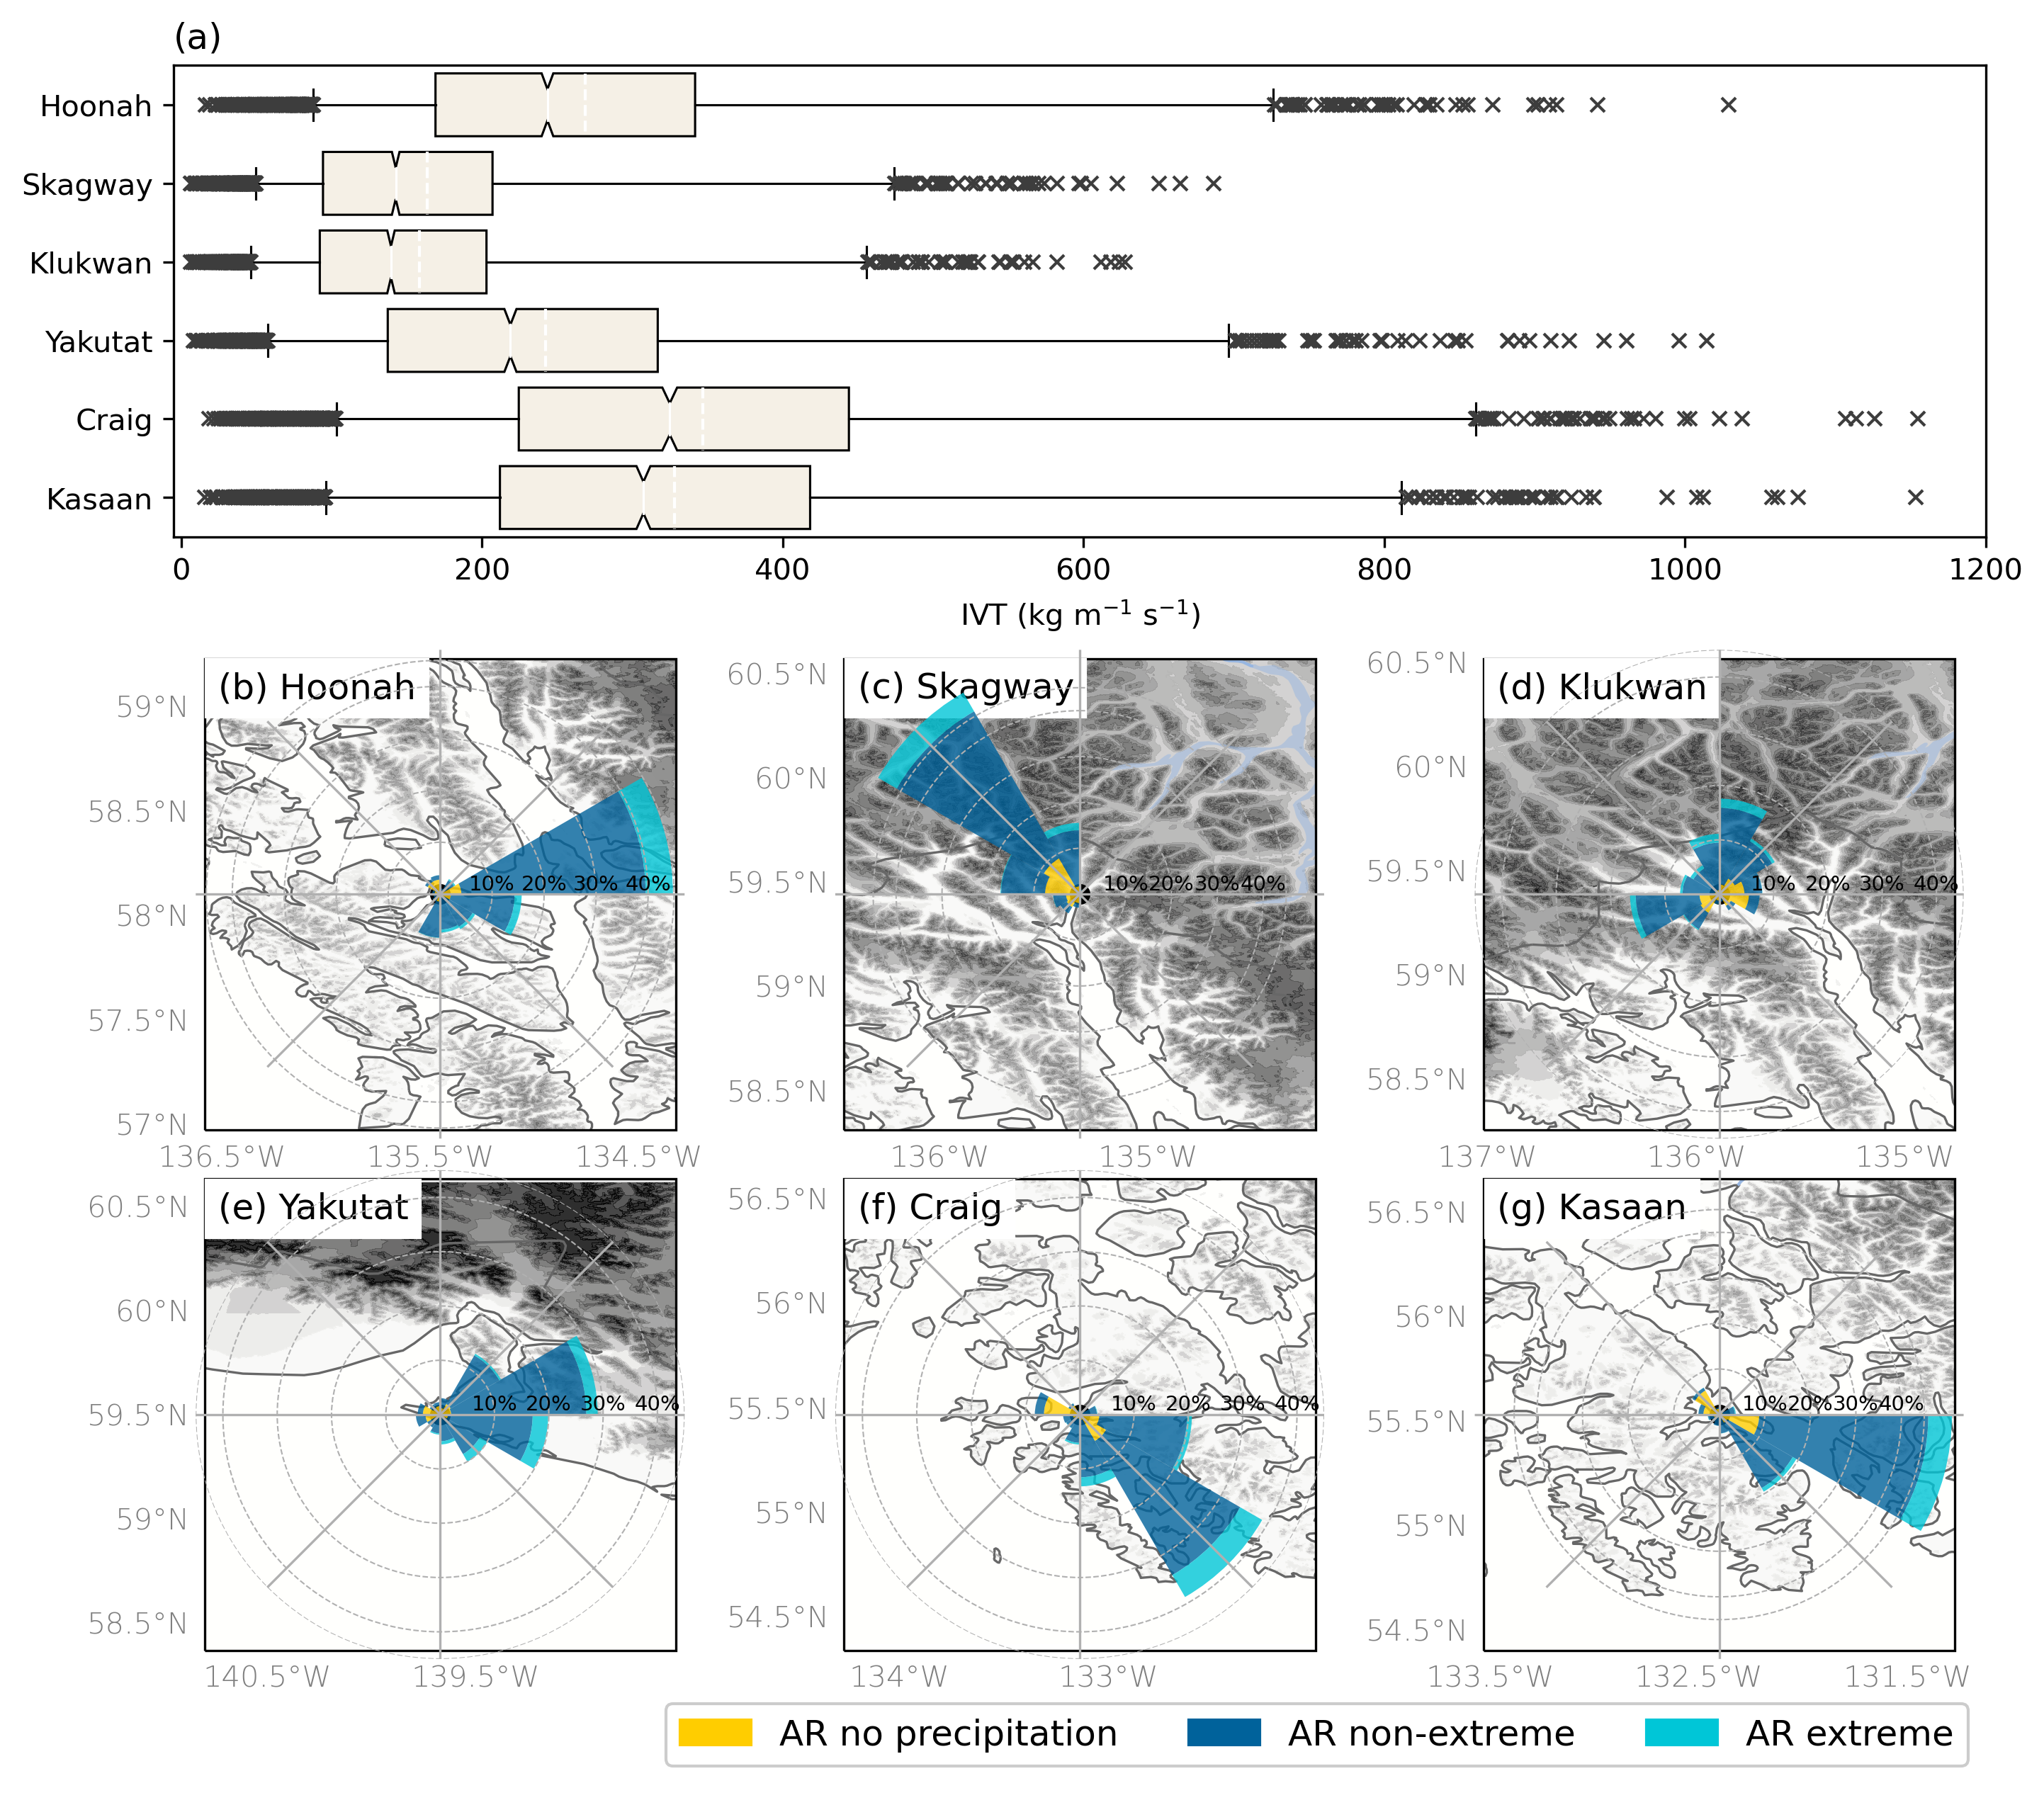

In [14]:
# Create figure
fig = plt.figure(figsize=(11, 10.5))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_UVwindrose_elev-overlay_{0}'.format(temporal_res)
fmt = 'png'

nrows = 6
ncols = 3

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05, 1, 1, 0.025, 0.05], width_ratios = [1, 1, 1], wspace=0.2, hspace=0.2)
## use gs[rows index, columns index] to access grids

#######################
### BOX AND WHISKER ###
#######################
ax = fig.add_subplot(gs[0, :])
PROPS = {'boxprops':{'facecolor':'#F5F0E6', 'edgecolor':'k'},
         'medianprops':{"color": "white"},
         'whiskerprops':{"color": "k"},
         'capprops':{"color": "k"},
         'flierprops':{"marker": "x"},
         'meanprops':{'c':'white', 'lw':1}}

bplot = sns.boxplot(y="Community", x="IVT", data=df_tidy, whis=[5, 99],
                order=community_lst,
                meanline=True, showmeans=True, 
                notch=True, showcaps=True,
                linewidth=0.75,
                **PROPS)
    
plt.xlim(-5, 1200)
    
ax.set_title('(a)', loc='left')
# ax.annotate(plt_lbl[i], (5, 207), xycoords='axes points', fontsize=12.,
#         backgroundcolor='white', zorder=100)

ax.set_xlabel('IVT (kg m$^{-1}$ s$^{-1}$)')
ax.set_ylabel('')

################
### WINDROSE ###
################

rowidx_lst = [2, 2, 2, 3, 3, 3]
colidx_lst = [0, 1, 2, 0, 1, 2]
for k, (rowidx, colidx) in enumerate(zip(rowidx_lst, colidx_lst)):
    ax = fig.add_subplot(gs[rowidx, colidx], projection=mapcrs)
    
    # Set tick/grid locations
    diff = 0.5
    ext = ext_lst[k]
    dx = np.arange(round(ext[0]),round(ext[1])+diff,diff)
    dy = np.arange(round(ext[2]),round(ext[3])+diff,diff)
    
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)
    
    # ## topo with grey-scale cmap
    # cs = ax.pcolormesh(elev.lon, elev.lat, elev.hillshade, rasterized=False, cmap=cmo.gray, shading='auto', transform=datacrs, alpha=0.8)
    clevs = np.arange(250, 3000, 250)
    cs = ax.contourf(elev.lon, elev.lat, elev.elev, transform=datacrs,
                     levels=clevs, cmap=cmo.gray_r, alpha=0.8, extend='both')
    
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # need this to fix transform for windrose location
    transform = datacrs._as_mpl_transform(ax)

    # Plot Location of community pts
    ax.plot(xs[k], ys[k], 'ko', markersize=6, transform=datacrs)

    ## plot windrose overlay
    df = df_lst[k]
    data = df.loc[(df.AR == 1)] # get only AR days
    # data = data.dropna() # remove days where no precipitation
    data = data.fillna(0) ## fill nans with zero
    # set prec bins for each community
    prec_bins = prec_bins_lst[k]
    rose = calc_rose(data, prec_bins, prec_labels, dir_bins, dir_labels)
    print(rose)
        
    bax = build_rose(xs[k], ys[k], ax, 2.3, rose, directions, False, rad_ticks, transform)
    
    titlestring = '({0}) {1}'.format(letter_lst[k+1], community_lst[k])
    ax.text(0.029, 0.973, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=110)
    
##Add color bar
cbax = plt.subplot(gs[-1,:]) # colorbar axis
# cmap = cmo.rain
# bounds = prec_bins[:]
# norm = mcolors.BoundaryNorm(bounds, cmap.N)
# cb = ColorbarBase(cbax, cmap=cmap,
#                   norm=norm,
#                   boundaries=bounds,
#                   extend='neither',
#                   ticks=bounds,
#                   spacing='proportional',
#                   orientation='horizontal')
# # cb.set_label('precipitation (mm day$^{-1}$)')
# cb.ax.tick_params(labelsize=12)

# create legend (of the 2 classes)
cbax.axis('off')
patch0 = mpatches.Patch(color=ucsd_colors['yellow'], label='AR no precipitation')
patch1 = mpatches.Patch(color=ucsd_colors['blue'], label='AR non-extreme')
patch2 = mpatches.Patch(color=ucsd_colors['aqua'], label='AR extreme')
cbax.legend(handles=[patch0, patch1, patch2], loc='lower right', framealpha=1.0, ncol=3, fontsize=12).set_zorder(200)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)

# Show
plt.show()